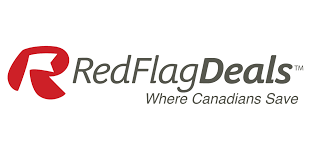

[RedFlagDeals](https://forums.redflagdeals.com/hot-deals-f9/) is a forum where users can post sales or deals that they have come accross. The first part of this project is focused on scraping relevant information from the "All Hot Deals" section that includes all product categories. In the second and third part I will clean and visualize the data to extract and summarize useful information.  

|Column name|Description|
|---|---|
|'title'| Title of post|
|'votes'| Sum of up-, and down-votes|
|'source'| Name of retailer offering the sale|
|'creation_date'| Date of initial post|
|'last_reply'| Date of most recent reply|
|'author'| User name of post author|
|'replies'| Number of replies|
|'views'| Number of views|
|'price'| Price of product on sale|
|'saving'| Associated saving|
|'expiry'| Expiry date of sale|
|'url'| Link to deal|

In [4]:
# Packages
import requests # Scraping
from bs4 import BeautifulSoup # HTML parsing
import pandas as pd
import numpy as np
import datetime
import re

## I. Retrieving data from the "All Hot Deals" sub-forum

URL format for different pages: `root-url/page#/`

In [11]:
# Initialize global variables used to iterate over web-pages.
current_page = "" # page number; used to format root URL
total_pages = 1 # endpoint for iteration; set through get_posts()
root_url = "https://forums.redflagdeals.com/hot-deals-f9/" # base url for "All Hot Deals" sub-forum

# URL base to generate links to specific posts
base_url = "https://forums.redflagdeals.com"

# Dataframe to store scraped data
table = pd.DataFrame(columns=
    ['title',
    'votes',
    'source',
    'creation_date',
    'last_reply',
    'author',
    'replies',
    'views',
    'price',
    'saving',
    'expiry',
    'url'])

In [12]:
def get_posts(page: str) -> list:
    """
    Returns list of parsed object containing all post elements from
    the current 'page' and sets gloabl variable 'total_pages'
    
    Args:
    page - url string of current page
    
    Returns:
    topics - all parsed elements of class 'row topic'
    total_pages - sets global variable
    """
    
    # Initalize list of posts on page class="row topic"
    posts = []
    
    # Get entire page content
    response = requests.get(page)
    content = response.content
    
    # Find total number of pages and set global variable accordingly
    # Format of text: " {current page #} of {total page #} "
    # Need to strip white space and extract total page #
    parser = BeautifulSoup(content, 'html.parser')
    pages = parser.select(".pagination_menu_trigger")[0].text.strip().split("of ")[1]
    global total_pages
    total_pages = int(pages)
    
    # Find and return topics
    topics = parser.find_all("li", class_="row topic")
    return topics

In [13]:
def get_additional_info(post: str) -> dict:
    """
    Extracts and returns additional information from a RedFlagDeal post:
    url-link to the deal, the price of the product, the discount saving, 
    the expiry date and the parent/thread categories of the product. Returns 
    NaN values for objects that are not found.
    
    Args:
    post - url string linking to a specific post
    
    Returns:
    additional_info - dictionary containing additional information about the post.
    """
    
    # Additional information found in post
    additional_info = {}
    
    # Get content of post
    response = requests.get(post)
    content = response.content
    parser = BeautifulSoup(content, 'html.parser')
    
    # Thread-header with information on parent and thread category
    try: # parent category
        parent_category = parser.select(".thread_parent_category")[0].text
        additional_info['Parent:'] = parent_category
    except: additional_info['Parent:'] = np.nan # NaN if category not found
    try: # thread category
        thread_category = parser.select(".thread_category")[0].text
        additional_info['Thread:'] = thread_category
    except: additional_info['Thread:'] = np.nan # NaN if category not found
    
    
    # Offer-summary field: may contain deal link, price, saving, and retailer
    summary = parser.select(".post_offer_fields") # format example: "Price:\n$200\nSaving:\n70%"
    try:
        summary_list = summary[0].text.split("\n") 
    except: summary_list = []
        
    # Go through summary elements and save relevant information
    for i in range(1, (len(summary_list) -1), 2): # index 0 is empty string
        current_element = summary_list[i] # content of current list element
        next_element = summary_list[i+1] # next list element
        
        # Price, saving, and expiry date information contained in the next list element will be saved
        if current_element.startswith("Price") or current_element.startswith("Saving") or current_element.startswith("Expiry"):
            additional_info[current_element]  = next_element # next elements corrsponds to content
            
    # URL to link. Full link not available through .text
    try: 
        url = str(summary[0]).split('href="')[1].split('"')[0] # select link between href=" and "
        additional_info['Link:'] = url
    except: additional_info['Link:'] = np.nan
        
    
    # If any of the elements is not found in the summary-field add None value to dictionary 
    if "Price:" not in additional_info:
        additional_info['Price:'] = np.nan
        
    if "Savings:" not in additional_info:
        additional_info['Savings:'] = np.nan
        
    if "Expiry:" not in additional_info:
        additional_info['Expiry:'] = np.nan
    
    return additional_info # Return dictionary containing with information on price, saving and expiry  

In [14]:
def fill_table(posts: list) -> None:
    '''
    Extracts parsed data from current page and appends to the global table variable.
    
    Args:
    posts - list of parsed post elements obtained through get_posts()
    '''
    
    # Temporary DataFrame object that will be appended to the global 'table' variable
    tmp_table = pd.DataFrame() 
    
    # Initializing columns for tmp_table
    title_col = pd.Series()
    source_col = pd.Series()
    url_col = pd.Series()
    votes_col = pd.Series()
    replies_col = pd.Series()
    views_col = pd.Series()
    creation_date_col = pd.Series()
    last_reply_col = pd.Series()
    author_col = pd.Series()
    price_col = pd.Series()
    saving_col = pd.Series()
    expiry_col = pd.Series()
    parent_col = pd.Series()
    thread_col = pd.Series()
    

    # Iterate through post elements on current page and extract data for table
    for post in posts:
        
        # Retailer corresponding to deal
        try: 
            source = post.select(".topictitle_retailer")[0].text.split("\n")[0] # split and remove line-break characters
            source_series = pd.Series(source) # transforming into Series object allows use of .append method
        except: source_series = pd.Series(np.nan)
        source_col = source_col.append(source_series, ignore_index=True)

        # Number of votes
        try: 
            votes = post.select(".post_voting")[0].text.split("\n")[1] 
            votes_series = pd.Series(votes) 
        except: votes_series = pd.Series(0)
        votes_col = votes_col.append(votes_series, ignore_index=True)
            
        # Title 
        try:
            topic = post.select(".topic_title_link") 
            title = topic[0].text.split('\n')[1] 
            title_series = pd.Series(title)
        except: title_series = pd.Series(np.nan)
        title_col = title_col.append(title_series, ignore_index=True)

        # Date of initial posting
        try: 
            creation = post.select(".first-post-time")[0].text.split("\n")[0]
            creation_series = pd.Series(creation)
        except: creation_series = pd.Series(np.nan)
        creation_date_col = creation_date_col.append(creation_series, ignore_index=True) 
        
        # Date of most recent replie
        try: 
            last_replie = post.select(".last-post-time")[0].text.split("\n")[0]
            last_replie_series = pd.Series(last_replie)
        except: last_replie_series = pd.Series(np.nan)
        last_reply_col = last_reply_col.append(last_replie_series, ignore_index=True) 
        
        # Author user-name
        try:
            author = post.select(".thread_meta_author")[0].text.split("\n")[0]
            author_series = pd.Series(author)
        except: author_series = pd.Series(np.nan)
        author_col = author_col.append(author_series, ignore_index=True)
        
        
        # Number of replies
        try:
            replies = post.select(".posts")[0].text.split("\n")[0]
            replies = replies.replace(",","") # remove commas to facilitate data type conversion to integer
            replies_series = pd.Series(replies)
        except: replies_series = pd.Series(np.nan)
        replies_col = replies_col.append(replies_series, ignore_index=True)
        
        # Number of views
        try:
            views = post.select(".views")[0].text.split("\n")[0]
            views = views.replace(",","") # remove commas to facilitate integer conversion
            views_series = pd.Series(views)
        except: replies_series = pd.Series(np.nan)
        views_col = views_col.append(views_series, ignore_index=True)
        
        # Link to current post
        try:
            link = str(topic).split('href="')[1] # split at href to extract link
            link_clean = link.split('">')[0] # remove superfluous characters
        except: 
            link_clean = np.nan
        
        # Additional information post
        if link_clean != None: # retrieve information from post, if url exists
            complete_url = (base_url + "{}").format(link_clean) # merge base-, and sub-url to generate the complete post-link
            additional_info = get_additional_info(complete_url) # get dictionary of additonal information on price, saving, etc.
            
            # Fill columns with additional information from additional_info dictionary
            price_col = price_col.append(pd.Series(additional_info['Price:']), ignore_index=True)
            saving_col = saving_col.append(pd.Series(additional_info['Savings:']), ignore_index=True)
            expiry_col = expiry_col.append(pd.Series(additional_info['Expiry:']), ignore_index=True)
            url_col = url_col.append(pd.Series(additional_info['Link:']), ignore_index=True)
            parent_col = parent_col.append(pd.Series(additional_info['Parent:']), ignore_index=True)
            thread_col = thread_col.append(pd.Series(additional_info['Thread:']), ignore_index=True)
        else:
            price_col = price_col.append(np.nan)
            saving_col = saving_col.append(np.nan)
            expiry_col = expiry_col.append(np.nan)
            url_col = url_col.append(np.nan)
        
            
    # Fill temporary table
    tmp_table['title'] = title_col
    tmp_table['votes'] = votes_col.astype(int)
    tmp_table['source'] = source_col
    tmp_table['creation_date'] = creation_date_col
    tmp_table['last_reply'] = last_reply_col
    tmp_table['author'] = author_col
    tmp_table['replies'] = replies_col.astype(int)
    tmp_table['views'] = views_col.astype(int)
    tmp_table['price'] = price_col
    tmp_table['saving'] = saving_col
    tmp_table['expiry'] = expiry_col
    tmp_table['url'] = url_col
    tmp_table['parent_category'] = parent_col
    tmp_table['thread_category'] = thread_col
        
    # Print result
    global table # gloabal keyword allows modification inside function
    table = table.append(tmp_table)
    print("Current table length: ", table.shape[0])

In [15]:
# Get first page information, and set total_pages through get_posts()
print('Extracting information from page: 1')
posts = get_posts(root_url)  
# Extract infomation from first page to fill table with data
fill_table(posts)

#Loop through pages and add data to table
for page in range(2, (total_pages + 1):
    next_url = root_url + str(page) + "/" # URL of next page: base-url + number + "/"
    print('Extracting information from page: ', page, " of ", total_pages)
    # Generate list of posts on current page
    posts = get_posts(next_url)

    # Fill table from information on current page and posts
    fill_table(posts)

Extracting information from page: 1
Current table length:  30
Extracting information from page:  2  of  51
Current table length:  60
Extracting information from page:  3  of  51
Current table length:  90
Extracting information from page:  4  of  51
Current table length:  120
Extracting information from page:  5  of  51
Current table length:  150
Extracting information from page:  6  of  51
Current table length:  180
Extracting information from page:  7  of  51
Current table length:  210
Extracting information from page:  8  of  51
Current table length:  240
Extracting information from page:  9  of  51
Current table length:  270
Extracting information from page:  10  of  51
Current table length:  300
Extracting information from page:  11  of  51
Current table length:  330
Extracting information from page:  12  of  51
Current table length:  360
Extracting information from page:  13  of  51
Current table length:  390
Extracting information from page:  14  of  51
Current table length:  420

,author,creation_date,expiry,last_reply,parent_category,price,replies,saving,source,thread_category,title,url,views,votes
0,trystee,"Jan 1st, 2020 8:32 pm",NaN,"Jul 13th, 2020 3:25 pm",NaN,NaN,672,NaN,NaN,Groceries,[Various Retailers] Gift Card Deals And Discou...,NaN,365169,317
1,yellowmp5,"Jul 13th, 2020 1:29 pm",NaN,"Jul 13th, 2020 3:23 pm",NaN,NaN,26,NaN,Home Depot,Home & Garden,RYOBI 20% coupon barcode,NaN,2593,28
2,phoreoneone,"Jul 13th, 2020 12:34 pm",NaN,"Jul 13th, 2020 3:23 pm",NaN,NaN,23,NaN,Dell,Computers & Electronics,"Dell G5 - 15"" 144Hz, i7-10750H, 16GB, 512GB, R...",http://www.jdoqocy.com/click-749547-12105225?u...,2339,15
3,Blackdove77,"Jul 6th, 2020 12:49 pm","July 19, 2020","Jul 13th, 2020 3:23 pm",Computers & Electronics,NaN,413,100%,NaN,Video Games,Watchdogs 2 PC version free for Everyone,https://register.ubisoft.com/ubisoft-forward-r...,57748,180
4,hkhorace,"Jul 6th, 2020 9:56 am","July 12, 2020","Jul 13th, 2020 3:22 pm",NaN,1300,77,$200 off,Costco,Automotive,Quickjack 7000slx $200 off - $1300,https://www.costco.ca/quickjack-bl-7000slx-318...,15093,26
5,jugojugo,"Jul 8th, 2020 9:26 pm",NaN,"Jul 13th, 2020 3:22 pm",Home & Garden,NaN,87,NaN,Home Depot,Home Improvement & Tools,RYOBI 2020 Summer Tour - 20% off 18V + 40V too...,https://bit.ly/RYOBISummerTour,16592,28
6,idiotcanuck,"Jul 13th, 2020 12:06 pm","July 14, 2020","Jul 13th, 2020 3:22 pm",Computers & Electronics,517.99,20,NaN,Costco,Televisions,Hisense 55-in. 4K ULED Android Smart TV 55Q7G ...,https://www.costco.ca/hisense-55-in.-4k-uled-a...,1562,4
7,kooltilltheen,"Jul 7th, 2020 4:12 am",NaN,"Jul 13th, 2020 3:22 pm",NaN,NaN,51,NaN,NaN,Apparel,Upto 75% Off On Everything On Old Navy/Gap + E...,NaN,19157,16
8,tmd2006,"Jul 13th, 2020 11:49 am",NaN,"Jul 13th, 2020 3:21 pm",Kids & Babies,199,7,NaN,Costco,Toys & Games,Costco.ca Geometric dome climbing structure $199,https://www.costco.ca/lifetime-geometric-dome-...,2499,3
9,fangdragon2000,"Jul 9th, 2020 11:51 am",NaN,"Jul 13th, 2020 3:20 pm",Computers & Electronics,"139,99",65,30$,Amazon.ca,Peripherals & Accessories,ADATA USA Ultimate Su800 1TB 3D Nand 2.5 Inch ...,http://www.amazon.ca/gp/redirect.html?ie=UTF8&...,8986,3


In [16]:
# Write data to csv file
table.to_csv('C:/Users/User/Documents/GitHub/Data-Science/rfd_scrape.csv')

## Load data and explore

In [63]:
df_raw = pd.read_csv('rfd_scrape.csv').iloc[:,1:]
df_raw.head()

,author,creation_date,expiry,last_reply,parent_category,price,replies,saving,source,thread_category,title,url,views,votes
0,trystee,"Jan 1st, 2020 8:32 pm",NaN,"Jul 13th, 2020 3:25 pm",NaN,NaN,672,NaN,NaN,Groceries,[Various Retailers] Gift Card Deals And Discou...,NaN,365169,317
1,yellowmp5,"Jul 13th, 2020 1:29 pm",NaN,"Jul 13th, 2020 3:23 pm",NaN,NaN,26,NaN,Home Depot,Home & Garden,RYOBI 20% coupon barcode,NaN,2593,28
2,phoreoneone,"Jul 13th, 2020 12:34 pm",NaN,"Jul 13th, 2020 3:23 pm",NaN,NaN,23,NaN,Dell,Computers & Electronics,"Dell G5 - 15"" 144Hz, i7-10750H, 16GB, 512GB, R...",http://www.jdoqocy.com/click-749547-12105225?u...,2339,15
3,Blackdove77,"Jul 6th, 2020 12:49 pm","July 19, 2020","Jul 13th, 2020 3:23 pm",Computers & Electronics,NaN,413,100%,NaN,Video Games,Watchdogs 2 PC version free for Everyone,https://register.ubisoft.com/ubisoft-forward-r...,57748,180
4,hkhorace,"Jul 6th, 2020 9:56 am","July 12, 2020","Jul 13th, 2020 3:22 pm",NaN,1300,77,$200 off,Costco,Automotive,Quickjack 7000slx $200 off - $1300,https://www.costco.ca/quickjack-bl-7000slx-318...,15093,26


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 15 columns):
Unnamed: 0         1500 non-null int64
author             1500 non-null object
creation_date      1500 non-null object
expiry             451 non-null object
last_reply         1500 non-null object
parent_category    920 non-null object
price              1017 non-null object
replies            1500 non-null int64
saving             591 non-null object
source             1115 non-null object
thread_category    1496 non-null object
title              1500 non-null object
url                1163 non-null object
views              1500 non-null int64
votes              1500 non-null int64
dtypes: int64(4), object(11)
memory usage: 175.9+ KB


In [7]:
df_raw.describe(include='all')

,Unnamed: 0,author,creation_date,expiry,last_reply,parent_category,price,replies,saving,source,thread_category,title,url,views,votes
count,1500.000000,1500,1500,451,1500,920,1017,1500.000000,591,1115,1496,1500,1163,1500.000000,1500.000000
unique,NaN,1067,1467,79,1415,12,684,NaN,306,163,55,1499,1145,NaN,NaN
top,NaN,immad01,"Jul 13th, 2020 12:24 pm","July 2, 2020","Jul 13th, 2020 3:17 pm",Computers & Electronics,Free,NaN,50%,Amazon.ca,Computers & Electronics,Ooma Telo Home phone service device $99.99,https://register.ubisoft.com/ubisoft-forward-r...,NaN,NaN
freq,NaN,39,3,34,5,385,16,NaN,32,231,177,2,2,NaN,NaN
mean,14.500000,NaN,NaN,NaN,NaN,NaN,NaN,48.782667,NaN,NaN,NaN,NaN,NaN,12812.877333,12.895333
std,8.658328,NaN,NaN,NaN,NaN,NaN,NaN,133.730488,NaN,NaN,NaN,NaN,NaN,31692.729533,31.407738
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,117.000000,-58.000000
25%,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,2136.250000,1.000000
50%,14.500000,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,NaN,NaN,NaN,NaN,NaN,4106.500000,4.000000
75%,22.000000,NaN,NaN,NaN,NaN,NaN,NaN,41.000000,NaN,NaN,NaN,NaN,NaN,10360.750000,14.000000


## II. Data wrangling

In [8]:
# Copy of raw data set
df = df_raw.copy()

# List of tuples: (column name, column dtype)
col_dtypes = [(col, type(x)) for x,col in zip(df.iloc[0], df.columns)]

# Print tuple for columns containing dates
for col in col_dtypes:
    if col[0] in ['creation_date', 'last_reply', 'expiry']:
        print(col[0], ': ', col[1])

creation_date :  <class 'str'>
expiry :  <class 'float'>
last_reply :  <class 'str'>


None of the columns are formatted as datetime. To facilitate working with the dates, we will convert them to datetime. 

### Convert date columns to datetime dtype

In [9]:
def to_datetime(column: str) -> pd.Series:
    """Converts a column of format "%b %d, %Y %I:%M %p" from string to date-time
    
    Args:
    date_column - name of column with dates encoded as strings
    
    Returns:
    Column elements converted to datetime in a pandas.Series object
    """    
    # Superfluous characters removed
    column_clean = df[column].str.replace("st","").str.replace("nd","").str.replace("rd","").str.replace("th","").str.strip()
    
    # Check for correct length of cleaned column
    column_len = len(column_clean)
    print("Cleaned and original column are of equal lenght: ", column_len == len(df[column]), "\n")
    
    # Convert from format "%b %d, %Y %I:%M %p" to datetime
    date_column = []
    try:
        date_column = column_clean.apply(lambda x : datetime.datetime.strptime(str(x), "%b %d, %Y %I:%M %p"))
    except: 
        print("\"%b %d, %Y %I:%M %p\" is incorrect format")
        pass
    
    # Convert from format "%B %d, %Y" to datetime
    for date in df[column]:
        if date is not np.nan:
            try:
                date_column.append(datetime.datetime.strptime(date, "%B %d, %Y"))
            except: 
                print("\"%B %d, %Y\" is incorrect format for", date)
                break
        else: 
            date_column.append(None)
    
    if len(date_column) != column_len:
        print("\n", "Incorrect column length!\n")
    else:
        print("\n", "Column has expected length!\n")
    
    return pd.Series(date_column)

In [10]:
# creation_date column converted to datetime
creation_date = to_datetime('creation_date')

# Compare random slice of original and converted column
print(creation_date.iloc[99:105], "\n")
print(df.loc[99:104, 'creation_date'])

Cleaned and original column are of equal lenght:  True 

"%B %d, %Y" is incorrect format for Jan 1st, 2020 8:32 pm

 Column has expected length!

99    2020-07-08 17:53:00
100   2020-07-11 20:38:00
101   2020-06-12 12:22:00
102   2020-07-13 11:35:00
103   2020-04-23 13:01:00
104   2020-07-13 11:58:00
Name: creation_date, dtype: datetime64[ns] 

99       Jul 8th, 2020 5:53 pm
100     Jul 11th, 2020 8:38 pm
101    Jun 12th, 2020 12:22 pm
102    Jul 13th, 2020 11:35 am
103     Apr 23rd, 2020 1:01 pm
104    Jul 13th, 2020 11:58 am
Name: creation_date, dtype: object


In [11]:
# last_reply column converted to datetime
last_reply = to_datetime('last_reply')

# Print original and new column for comparison
print(last_reply.iloc[208:215], "\n")
print(df.loc[208:214, 'last_reply'])

Cleaned and original column are of equal lenght:  True 

"%B %d, %Y" is incorrect format for Jul 13th, 2020 3:25 pm

 Column has expected length!

208   2020-07-12 20:04:00
209   2020-07-12 19:53:00
210   2020-07-12 19:47:00
211   2020-07-12 19:43:00
212   2020-07-12 19:28:00
213   2020-07-12 19:28:00
214   2020-07-12 19:10:00
Name: last_reply, dtype: datetime64[ns] 

208    Jul 12th, 2020 8:04 pm
209    Jul 12th, 2020 7:53 pm
210    Jul 12th, 2020 7:47 pm
211    Jul 12th, 2020 7:43 pm
212    Jul 12th, 2020 7:28 pm
213    Jul 12th, 2020 7:28 pm
214    Jul 12th, 2020 7:10 pm
Name: last_reply, dtype: object


In [12]:
# print(to_datetime('expiry').iloc[50:57], "\n")
# print(df.loc[50:56, 'expiry'])

Last logging:  
Date:  **Augu 24, 2020**    
date is not np.nan:  True  
dtype of date:  <class 'str'>  
"%B %d, %Y" is incorrect format for Augu 24, 2020  

From the last logging, it becomes apparent that `st` has been removed from August due to the use of str.replace() in the to_datetime() function. This is not an issue for the columns with a `%b` format for months. The solution is to use the uncleaned data for the `expiry` column.

In [13]:
expiry = to_datetime('expiry')
print(expiry.iloc[50:57], "\n")
print(df.loc[50:56, 'expiry'])

Cleaned and original column are of equal lenght:  True 

"%b %d, %Y %I:%M %p" is incorrect format

 Column has expected length!

50   2020-09-08
51   2020-07-23
52   2020-07-26
53          NaT
54          NaT
55          NaT
56          NaT
dtype: datetime64[ns] 

50    September 8, 2020
51        July 23, 2020
52        July 26, 2020
53                  NaN
54                  NaN
55                  NaN
56                  NaN
Name: expiry, dtype: object


The to_datetime() function appears to correctly convert each of the columns. The results can now be used in the DataFrame.

In [14]:
# Assign datetime columns to DataFrame
df.expiry = expiry
df.last_reply = last_reply
df.creation_date = creation_date

# Verify dates
df.head()

,Unnamed: 0,author,creation_date,expiry,last_reply,parent_category,price,replies,saving,source,thread_category,title,url,views,votes
0,0,trystee,2020-01-01 20:32:00,NaT,2020-07-13 15:25:00,NaN,NaN,672,NaN,NaN,Groceries,[Various Retailers] Gift Card Deals And Discou...,NaN,365169,317
1,1,yellowmp5,2020-07-13 13:29:00,NaT,2020-07-13 15:23:00,NaN,NaN,26,NaN,Home Depot,Home & Garden,RYOBI 20% coupon barcode,NaN,2593,28
2,2,phoreoneone,2020-07-13 12:34:00,NaT,2020-07-13 15:23:00,NaN,NaN,23,NaN,Dell,Computers & Electronics,"Dell G5 - 15"" 144Hz, i7-10750H, 16GB, 512GB, R...",http://www.jdoqocy.com/click-749547-12105225?u...,2339,15
3,3,Blackdove77,2020-07-06 12:49:00,2020-07-19,2020-07-13 15:23:00,Computers & Electronics,NaN,413,100%,NaN,Video Games,Watchdogs 2 PC version free for Everyone,https://register.ubisoft.com/ubisoft-forward-r...,57748,180
4,4,hkhorace,2020-07-06 09:56:00,2020-07-12,2020-07-13 15:22:00,NaN,1300,77,$200 off,Costco,Automotive,Quickjack 7000slx $200 off - $1300,https://www.costco.ca/quickjack-bl-7000slx-318...,15093,26


### Dealing with missing data: `source`

In [19]:
df.loc[:, ['source', 'title']].head()

,source,title
0,NaN,[Various Retailers] Gift Card Deals And Discou...
1,Home Depot,RYOBI 20% coupon barcode
2,Dell,"Dell G5 - 15"" 144Hz, i7-10750H, 16GB, 512GB, R..."
3,NaN,Watchdogs 2 PC version free for Everyone
4,Costco,Quickjack 7000slx $200 off - $1300


It is possible, that users simply forgot to include the source of the deal. We will check if missing sources are mentioned in the corresponding title.

In [20]:
# Set of entries in 'source' column
retailer_set = set(df['source'].dropna())
print("Number of unique sources: ", len(retailer_set))
print(df.source.isnull().sum(), "missing values in source column")

Number of unique sources:  163
385 missing values in source column


The large number of unique sources is promising! 

Next we will use the set previously created to itterate through the titles an check if any of the unique source names are present. If a source name from the set is found in `title` and no value is found in the corresponding `source` column, then the index as well as the source name are saved in the `replace` dictinoary.

In [36]:
replace_dict = {} # key: index; value: retailer name to replace missing source value at index
# found_in_title = {} # keys: retailer name; values: number of times name was found in a post-title
# source_in_title = [] # names of retailers mentioned in at least one title
# replaceable_value_count = 0

# Iterate throuh set of unique values from source source column
for retailer in retailer_set:
    """Fill replace dictioray with indecies and source names. Entries are made
    when a source name is found in the title column while the corresponding source entry
    is empty."""
    
    # Iterate through 'source' and 'title' columns row-by-row
    # Generate boolean array: True if unique source name (retailer) found in "title" and "source" is np.nan
    source_missing_and_in_title = np.array([retailer in title 
                                     if source is np.nan else False
                                     for title,source in zip(df.title, df.source)])
    
    # Indecies for which source_missing_and_in_title is True
    replacement_indicies = np.where(source_missing_and_in_title == True)[0]
    # Fill "replace" dictionary
    for index in replacement_indicies:
        if index not in replace_dict.keys():
            replace_dict[index] = retailer

print("Replacements found in 'title':", len(replace_dict.values()))

Replacements found in 'title': 53


53 missing sources can be replaced by information found in the title. We will use the indecies and values stored in `replace_dict` to replace the appropriate values.

In [37]:
source_list = list(df.source)
missing_start = sum([x is np.nan for x in source_list])
print("Missing source values before replacement:", missing_start)

for replace_source in replace.items():
    source_list[replace_source[0]] = replace_source[1]

missing_end = sum([x is np.nan for x in source_list])
print("Missing source values after replacement:", missing_end)
replaced_count = missing_start-missing_end
print(replaced_count, "missing source records have been replaced!")

Missing source values before replacement: 385
Missing source values after replacement: 332
53 missing source records have been replaced!


All 53 identified `source` records have been replaced with apporiate names of retailers found in the corrseponding `title` column. The new `source` column can now replace the old one.  

In [38]:
df.source = source_list
print("Number of missing values as expected:", (df.source.isnull().sum() == missing_end))

Number of missing values as expected: True


Further substitutions for missing `source` values may be found in the `url` column. The objective is to extract company names from the urls and use them to further replace missing values.

In [40]:
# 'url' entries of rows with missing source values
url_replacement = df[df.source.isnull()].url
print(url_replacement.notnull().sum(), "missing source values have corresponding urls")
url_replacement.head()

262 missing source values have corresponding urls


0                                                   NaN
3     https://register.ubisoft.com/ubisoft-forward-r...
17    http://go.redirectingat.com?id=2927x594702&amp...
19    http://click.linksynergy.com/deeplink?id=CAqD7...
22        https://www.costco.ca/.product.100476333.html
Name: url, dtype: object

The urls need to be split and cleaned to extract the name of the organisation. The final cleaned values and their corresponding indicies in the DataFrame will be stores in the `clean_urls` disctionary.

In [41]:
clean_urls = {} # key: index in df, value: cleaned url
indicies = url_replacement.index

for url in zip(indicies, url_replacement):
    index = url[0]
    replacement_url = url[1]
    
    # Clean if url value not missing
    if replacement_url is not np.nan:
        url_root = replacement_url.split("//")[1].split("/")[0].split("?")[0].replace("www.", "")
        removed_domain = url_root.split(".")
        clean_urls[index] = removed_domain
    else:
        clean_urls[index] = np.nan
        
print(clean_urls)

{0: nan, 3: ['register', 'ubisoft', 'com'], 17: ['go', 'redirectingat', 'com'], 19: ['click', 'linksynergy', 'com'], 22: ['costco', 'ca'], 23: nan, 27: ['activebaby', 'ca'], 41: ['classic', 'avantlink', 'com'], 45: ['awin1', 'com'], 46: nan, 49: ['awin1', 'com'], 54: ['ebox', 'ca'], 59: ['awin1', 'com'], 62: ['store', 'insta360', 'com'], 63: ['amazon', 'ca'], 65: ['costco', 'ca'], 71: ['cityfone', 'net'], 77: ['alltrails', 'com'], 80: ['costco', 'ca'], 81: ['click', 'linksynergy', 'com'], 84: nan, 87: ['econsumer', 'equifax', 'ca'], 91: nan, 94: nan, 103: nan, 113: ['amazon', 'ca'], 122: nan, 141: ['svpsports', 'ca'], 147: ['amazon', 'ca'], 151: nan, 152: ['bcfasteners', 'com'], 156: ['costco', 'ca'], 157: ['staplescanada', '4u8mqw', 'net'], 165: nan, 166: ['register', 'ubisoft', 'com'], 168: ['apps', 'apple', 'com'], 169: ['amazon', 'ca'], 171: ['amazon', 'ca'], 172: ['mailchi', 'mp'], 178: ['amazon', 'ca'], 180: ['bccamera', 'com'], 183: ['amazon', 'ca'], 187: ['tkqlhce', 'com'], 191

We want to identify the company names from the url splits observed in the print above.
The patterns shown in the table will facilitate this process. This is an oversimplification and will lead to some false extractions but the number of errors should be minimal.

|Condition| Pattern|
|---|---|
|Lists length 2| company name is at index 0|
|Lists length 3 and domain com, ca, or net| name is at index 1|
|List length 3 and domain io| name is at index 0| 
|List length 4| no identifiable name|

In [42]:
clean_url_final = clean_urls.copy()

for item in clean_url_final.items():
    index = item[0]
    url_split = item[1]
    try:
        if len(url_split) == 2:
             # name at index 0
            clean_url_final[index] = url_split[0].title()
        
        elif ((len(url_split) == 3) 
                        and ((url_split[-1] == "com") 
                                 or (url_split[-1] == "ca") 
                                 or (url_split[-1] == "ca"))):
            # name at index 1
            clean_url_final[index] = url_split[1].title()
        
        elif ((len(url_split) == 3) 
                        and (url_split[-1] == "io")):
             # name at index 0
            clean_url_final[index] = url_split[0].title()
        else: 
              clean_url_final[index] = np.nan
    except: value = np.nan

In [43]:
# Add url-derived company names to DataFrame
df.loc[list(clean_url_final.keys()),'source'] = list(clean_url_final.values())
print("Missing source values remaining: ", df.source.isnull().sum())

Missing source values remaining:  78


### Dealing with missing data: `price`

Users may have forgoten to tag prices associated with the deals they posted. We will verify if their are any `$` signs in the title for those rows that have missing price values.

In [44]:
missing_prices_df = df[df.price.isnull()]
price_in_title = ["$" in title for title in missing_prices_df.title]
print(df.price.isnull().sum(), "missing values in 'price' column")
print(sum(price_in_title), "missing prices have '$' signs in the title") 

483 missing values in 'price' column
246 missing prices have '$' signs in the title


In [47]:
# Display first 10 title to evaluate if the missing price could be substituted
replacement_titles = missing_prices_df[price_in_title].title
[title for title in replacement_titles][0:10]

['Dell G5 - 15" 144Hz, i7-10750H, 16GB, 512GB, RTX 2060 $1,549 ($1425/$1285 Rakuten/Rakuten+Uni)',
 'iTunes gift cards - $21.49 for $25 | $84.99 for $100 | $167.99 for $200 (Members only)',
 'Lenovo Duet Chromebook 2-in-1: $399 - preorder',
 '[Uplay/Steam] Far Cry 5 (11.99$) - Far Cry 4 (7.99$) - Far Cry 3 (3.90$)',
 'Ebay - Take $5 off minimum purchase of $5.01 YMMV',
 'Samsung Galaxy S10 Lite (6.7", 128GB, 8GB, SD855, 4500mah) US$431 / CAD$585 (and Note 10 Lite CAD$572)',
 'Amex Business Platinum: $250 credit for $250 spend at dell.ca',
 'Shopping.ca Gift Card by Ivanhoé Cambridge - Spend at least $100 and Earn $20 credit. Up to 3 times - YMMV',
 'Samsung CRG9 - 49inch 1440p 120hrz monitor $1299 Best Buy',
 'Book Outlet - Many Low Prices on Books (Free Shipping Over $45 & 16% Off)']

In [48]:
regex = "[$]+[.,]*\d+[.,]*\d+"\
        "|[.,]*\d+[.,]*\d+[$]+"\
        "|[a-zA-Z]+[$]+[.,]*\d+[.,]*\d+"
price_replacements = replacement_titles.str.findall(regex)
print("Number of possible replacements:", len(price_replacements))
price_replacements

Number of possible replacements: 246


2                           [$1,549, $1425, $1285]
12      [$21.49, $25, $84.99, $100, $167.99, $200]
16                                          [$399]
17                          [11.99$, 7.99$, 3.90$]
23                                         [$5.01]
                           ...                    
1465                                         [$49]
1485                                        [$139]
1488                                    [$60, $20]
1493                                    [$10, $14]
1498                            [$169.95, $199.95]
Name: title, Length: 246, dtype: object

We'll assume the first element in each list is most relevant and use it to replace missing price values. Some inaccuracies are likely to occure but the estimates should be reasonable.

In [51]:
replacement_dict = {} # key: index; value: price to replace missing value at index

# Iterate through price lists found in price_replacements and corresonding indecies in DataFrame
for replacement in zip(price_replacements, list(price_replacements.index)):
    price_list = replacement[0]
    index = replacement[1]
    if price_list != []:
        price = price_list[0]
        price_clean = (re.search(r"\d+[.,]*\d+", price)).group().replace(",","")
        replacement_dict[index] = price_clean
        
print(len(replacement_dict), "replacements found.")

231 replacements found.


In [52]:
# Replace missing values
df.loc[list(replacement_dict.keys()), 'price'] = list(replacement_dict.values())
print("Remaining missing values:", df.price.isnull().sum())

Remaining missing values: 252


ImportError: cannot import name 'Statistics' from 'math' (unknown location)